# Extract phenometrics over IBRA subregions

This is both for testing, and for producing examples to highlight the function of the algorithm etc.

In [1]:
%matplotlib inline

import sys
import pickle
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.geo.geom import Geometry
from odc.geo.xr import assign_crs

sys.path.append('/g/data/os22/chad_tmp/Aus_phenology/src')
from phenology_pixel import _extract_peaks_troughs, xr_phenometrics

# %load_ext autoreload
# %autoreload 2

Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead


## Analysis Parameters


In [2]:
product='AusENDVI-clim_MCD43A4'
timeseries_file = '/g/data/os22/chad_tmp/Aus_phenology/data/pickle/IBRA_subregions_NDVI_'+product+'.pkl'
save_file = '/g/data/os22/chad_tmp/Aus_phenology/data/pickle/IBRA_subregions_'+product+'_phenometrics_new.pkl'
ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_subregions_modified.geojson'
var='SUB_NAME_7'
region_type = 'IBRA_subregions'
years='1982-2022'

## Open data

In [3]:
#NDVI timeseries processed earlier to daily
with open(timeseries_file, 'rb') as f:
    results = pickle.load(f)

gdf = gpd.read_file(ecoregions_file)

#bare soil NDVI data
ss_path = f'/g/data/xc0/project/AusEFlux/data/ndvi_of_baresoil_5km.nc'
ss = assign_crs(xr.open_dataset(ss_path)['NDVI'], crs='epsg:4326')
ss.name = 'NDVI'

## Extract phenometrics 

<!-- import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def double_logistic_function(t, wNDVI, mNDVI, S, A, mS, mA):
    sigmoid1 = 1 / (1 + np.exp(-mS * (t - S)))
    sigmoid2 = 1 / (1 + np.exp(mA * (t - A)))
    seasonal_term = sigmoid1 + sigmoid2 - 1
    return wNDVI + (mNDVI - wNDVI) * seasonal_term

def weight_function(t, S, A, r):
    tr = 100 * (t - S) / (A - S)
    tr = np.clip(tr, 0, 100)
    return np.exp(-np.abs(r) / (1 + tr / 10))

def fit_curve(t, ndvi_observed):
    initial_guess = [np.min(ndvi_observed), np.max(ndvi_observed), np.mean(t), np.mean(t), 1, 1]
    params, _ = curve_fit(double_logistic_function, t, ndvi_observed, p0=initial_guess, maxfev=10000)
    residuals = ndvi_observed - double_logistic_function(t, *params)
    weights = weight_function(t, params[2], params[3], residuals)
    params, _ = curve_fit(double_logistic_function, t, ndvi_observed, p0=initial_guess, sigma=weights, maxfev=10000)
    return params

doys = ndvi_cycle.time.dt.dayofyear.values[2:]
doys_frac = doys/365
values = ndvi_cycle.values[2:]

##Fit the curve
parameters = fit_curve(doys_frac, values)

##Plot the observed NDVI values
plt.scatter(doys, values, label='Observed NDVI')

##Generate points for the fitted curve
t_fit = np.linspace(min(doys_frac), max(doys_frac), 365)
ndvi_fit = double_logistic_function(t_fit, *parameters)

##Plot the fitted curve
plt.plot(t_fit*365, ndvi_fit, label='Fitted Curve', color='red')

plt.xlabel('Day of the Year')
plt.ylabel('NDVI')
plt.legend()
plt.title('Double Logistic Curve Fitting for NDVI Observations')
plt.show() -->

In [ ]:
pheno={}
i=0
for index, row in gdf.iterrows():
    print(" {:02}/{:02}\r".format(i + 1, len(range(0, len(gdf)))), end="")

    if row['SUB_NAME_7'] == 'Coral Se':
        continue

    if row['SUB_NAME_7'] == 'Timor Sea Coral Islands':
        continue
    
    ds = results[row[var]]

    #bare soil NDVI clip to region
    geom = Geometry(geom=gdf.iloc[index].geometry, crs=gdf.crs)
    soil = ss.odc.mask(poly=geom)
    soil = soil.mean().values.item()

    # fake expand dims
    ds = ds.expand_dims(latitude=[-33.0],longitude=[135.0])
    
    #apply pheno
    p = xr_phenometrics(ds,
                    rolling=90,
                    distance=90,
                    prominence='auto',
                    plateau_size=10,
                    amplitude=0.2,
                    verbose=True,
                    soil_signal=soil,
                       ).compute()
    
    p = p.squeeze().drop_vars(['latitude','longitude']).to_dataframe()

    pheno[row['SUB_NAME_7']] = p
    i+=1

## Save results

In [ ]:
with open(save_file, 'wb') as f:
    pickle.dump(pheno, f)

## Plot some regions

In [1]:
# gdf.explore(column='SUB_NAME_7',
#             tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#             attr = 'Esri',
#             name = 'Esri Satellite',
#             control = True,
#             legend=False
#            )

In [5]:
phenometrics_file = '/g/data/os22/chad_tmp/Aus_phenology/data/pickle/IBRA_subregions_AusENDVI-clim_MCD43A4_phenometrics_new.pkl'
with open(phenometrics_file, 'rb') as f:
    eco_regions_phenometrics = pickle.load(f)

In [6]:
k = 'Eastern Murchiso' #'Geraldton Hills rainfed crop' 'Weipa Plateau'

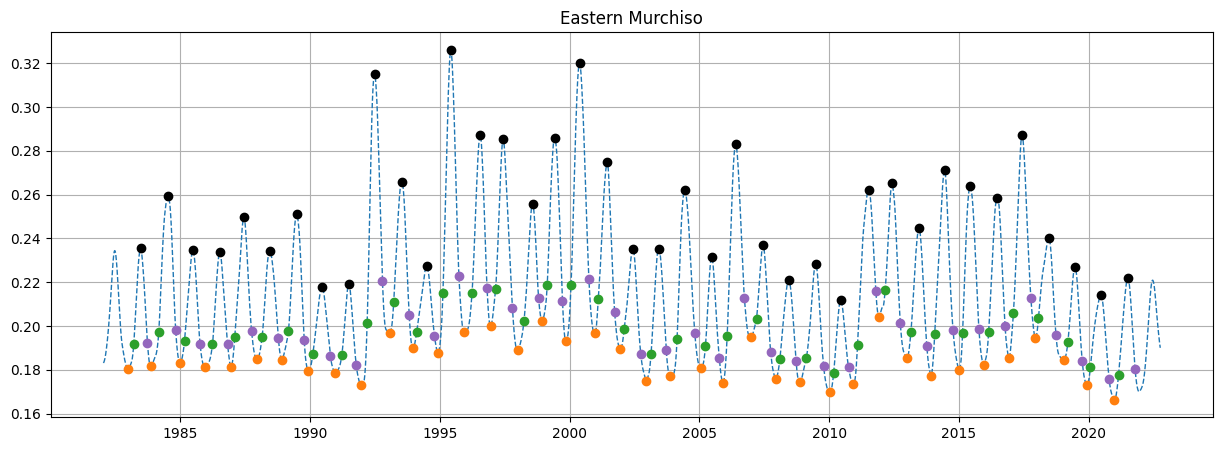

In [7]:
ds = results[k] #'Recherche rainfed crop'

fig,ax=plt.subplots(1,1, figsize=(15,5))
ds.plot(ax=ax, color='tab:blue', linestyle='--', linewidth=1.0, label='Daily NDVI') #.sel(time=slice('1997','2016'))

# ax.set_ylim(0.15, 0.7)
ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].SOS.values, eco_regions_phenometrics[k].SOS_year.values)],
       y=eco_regions_phenometrics[k].vSOS,
      c='tab:green', label='SOS', zorder=10)

ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].EOS.values, eco_regions_phenometrics[k].EOS_year.values)],
       y=eco_regions_phenometrics[k].vEOS,
      c='tab:purple', label='EOS', zorder=10)

ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].POS.values, eco_regions_phenometrics[k].POS_year.values)],
           y=eco_regions_phenometrics[k].vPOS,
          c='black', label='POS', zorder=10)

ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].TOS.values, eco_regions_phenometrics[k].TOS_year.values)],
       y=eco_regions_phenometrics[k].vTOS,
      c='tab:orange', label='TOS', zorder=10)

ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_title(k, fontsize=12)
ax.grid()
# plt.ylim(0.1,0.4)

In [28]:
# fig, ax = plt.subplots(1,1, figsize=(7,7))
# for y in range(1982,2021):
#     ds.sel(time=str(y)).groupby('time.month').mean().plot(label=str(y), ax=ax)
# plt.legend()
    

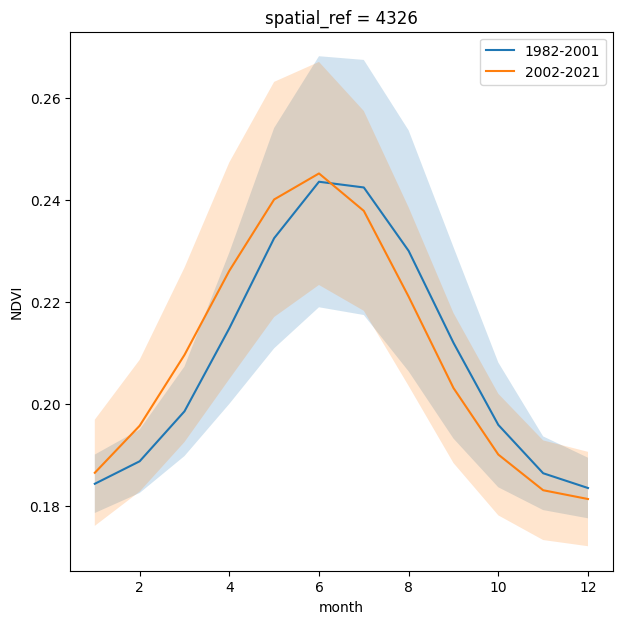

In [27]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
mean_early = ds.sel(time=slice('1982','1993')).groupby('time.month').mean()
mean_late = ds.sel(time=slice('2001','2021')).groupby('time.month').mean()

std_early = ds.sel(time=slice('1982','1993')).groupby('time.month').std()
std_late = ds.sel(time=slice('2001','2021')).groupby('time.month').std()

mean_early.plot(label='1982-2001')
ax.fill_between(mean_early.month, mean_early-std_early, mean_early+std_early, alpha=0.2)

mean_late.plot(label='2002-2021')
ax.fill_between(mean_late.month, mean_late-std_late, mean_late+std_late, alpha=0.2)
plt.legend()
# plt.title(k+' NDVI average annual cycle');